## Final Project 
### Blindness Detection
#### Group: Gareth Sun zs389, Zimu Li zl898, Arman Syed as3778


### 1. Data Preprocess

In [1]:
# Import the Library we need
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import torch
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1
True


In [3]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
print(device)

cuda


In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
# Load training Data
train_df = pd.read_csv('train.csv')
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
train_df['pic_id'] = train_df['id_code'].astype(str)+'.png'
train_df.head()

,id_code,diagnosis,pic_id
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


In [6]:
# Data Load
preprocessor = ImageDataGenerator(
    # Normalization
    rescale=1/255,
    # Use Data Augmentation to prevent overfitting
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # Split validation and training dataset
    validation_split=0.2
)

# Set the batch and image size
image_size = 64
batch_size = 32

train_pic = preprocessor.flow_from_dataframe(
    dataframe=train_df,
    directory='train_images',
    x_col='pic_id',
    y_col='diagnosis',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    target_size=(image_size, image_size)
)

test_pic = preprocessor.flow_from_dataframe(
    dataframe=train_df,
    directory='train_images',
    x_col='pic_id',
    y_col='diagnosis',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    target_size=(image_size, image_size)
)

# Covert category into one-hot code
train_label = pd.get_dummies(train_df['diagnosis'])
num_classes = train_label.shape[1]
num_samples = train_label.shape[0]

print(num_classes)
print(num_samples)


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
5
3662


### 2. Build CNN Model

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GaussianDropout

In [14]:
def cnn_model(image_size, num_classes):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(GaussianDropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(GaussianDropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
model = cnn_model(image_size, num_classes)
# Save the model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

tm = ModelCheckpoint('version1', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

class AccuracyPlotter(Callback):
    def on_train_begin(self, logs={}):
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

    def on_train_end(self, logs={}):
        plt.figure(figsize=(20,10))
        plt.plot(range(1, len(self.train_acc) + 1), self.train_acc, label='Training Accuracy')
        plt.plot(range(1, len(self.val_acc) + 1), self.val_acc, label='Validation Accuracy')
        plt.title('Accuracy Plot')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.xticks(range(1, len(self.train_acc) + 1))
        plt.legend()
        plt.grid(True)
        plt.show()
        
plotter = AccuracyPlotter()

Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 1.2830 - accuracy: 0.4872
Epoch 1: val_loss improved from inf to 1.23114, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 177s 2s/step - loss: 1.2830 - accuracy: 0.4872 - val_loss: 1.2311 - val_accuracy: 0.4602
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 1.0608 - accuracy: 0.5997
Epoch 2: val_loss improved from 1.23114 to 1.00193, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 176s 2s/step - loss: 1.0608 - accuracy: 0.5997 - val_loss: 1.0019 - val_accuracy: 0.6747
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.6912
Epoch 3: val_loss improved from 1.00193 to 0.89667, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 175s 2s/step - loss: 0.9010 - accuracy: 0.6912 - val_loss: 0.8967 - val_accuracy: 0.6733
Epoch 4/50
91/91 [==============================] - ETA: 0s - loss: 0.8540 - accuracy: 0.6957
Epoch 4: val_loss improved from 0.89667 to 0.85236, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 183s 2s/step - loss: 0.8540 - accuracy: 0.6957 - val_loss: 0.8524 - val_accuracy: 0.6847
Epoch 5/50
91/91 [==============================] - ETA: 0s - loss: 0.8394 - accuracy: 0.7091
Epoch 5: val_loss did not improve from 0.85236
91/91 [==============================] - 180s 2s/step - loss: 0.8394 - accuracy: 0.7091 - val_loss: 0.8904 - val_accuracy: 0.6889
Epoch 6/50
91/91 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.7126
Epoch 6: val_loss improved from 0.85236 to 0.84854, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 173s 2s/step - loss: 0.8270 - accuracy: 0.7126 - val_loss: 0.8485 - val_accuracy: 0.6989
Epoch 7/50
91/91 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.7136
Epoch 7: val_loss did not improve from 0.84854
91/91 [==============================] - 181s 2s/step - loss: 0.8128 - accuracy: 0.7136 - val_loss: 0.8694 - val_accuracy: 0.6903
Epoch 8/50
91/91 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.7157
Epoch 8: val_loss improved from 0.84854 to 0.83813, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 174s 2s/step - loss: 0.8121 - accuracy: 0.7157 - val_loss: 0.8381 - val_accuracy: 0.7060
Epoch 9/50
91/91 [==============================] - ETA: 0s - loss: 0.8007 - accuracy: 0.7181
Epoch 9: val_loss improved from 0.83813 to 0.82088, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 175s 2s/step - loss: 0.8007 - accuracy: 0.7181 - val_loss: 0.8209 - val_accuracy: 0.7145
Epoch 10/50
91/91 [==============================] - ETA: 0s - loss: 0.7816 - accuracy: 0.7215
Epoch 10: val_loss improved from 0.82088 to 0.80987, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 178s 2s/step - loss: 0.7816 - accuracy: 0.7215 - val_loss: 0.8099 - val_accuracy: 0.7060
Epoch 11/50
91/91 [==============================] - ETA: 0s - loss: 0.7950 - accuracy: 0.7195
Epoch 11: val_loss did not improve from 0.80987
91/91 [==============================] - 181s 2s/step - loss: 0.7950 - accuracy: 0.7195 - val_loss: 0.8678 - val_accuracy: 0.6889
Epoch 12/50
91/91 [==============================] - ETA: 0s - loss: 0.8001 - accuracy: 0.7188
Epoch 12: val_loss did not improve from 0.80987
91/91 [==============================] - 182s 2s/step - loss: 0.8001 - accuracy: 0.7188 - val_loss: 0.8237 - val_accuracy: 0.7074
Epoch 13/50
91/91 [==============================] - ETA: 0s - loss: 0.7739 - accuracy: 0.7222
Epoch 13: val_loss did not improve from 0.80987
91/91 [==============================] - 187s 2s/step - loss: 0.7739 - accuracy: 0.7222 - val_loss: 0.8224 - val_accuracy: 0.7088
Epoch 14/50
91/91 [==============================] 

INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 182s 2s/step - loss: 0.7703 - accuracy: 0.7208 - val_loss: 0.7932 - val_accuracy: 0.7116
Epoch 15/50
91/91 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.7257
Epoch 15: val_loss did not improve from 0.79319
91/91 [==============================] - 186s 2s/step - loss: 0.7778 - accuracy: 0.7257 - val_loss: 0.8010 - val_accuracy: 0.7159
Epoch 16/50
91/91 [==============================] - ETA: 0s - loss: 0.7544 - accuracy: 0.7219
Epoch 16: val_loss did not improve from 0.79319
91/91 [==============================] - 183s 2s/step - loss: 0.7544 - accuracy: 0.7219 - val_loss: 0.8137 - val_accuracy: 0.7088
Epoch 17/50
91/91 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.7264
Epoch 17: val_loss did not improve from 0.79319
91/91 [==============================] - 179s 2s/step - loss: 0.7587 - accuracy: 0.7264 - val_loss: 0.7981 - val_accuracy: 0.7202
Epoch 18/50
91/91 [==============================] 

INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 174s 2s/step - loss: 0.7392 - accuracy: 0.7322 - val_loss: 0.7824 - val_accuracy: 0.7102
Epoch 23/50
91/91 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.7315
Epoch 23: val_loss improved from 0.78242 to 0.78000, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 181s 2s/step - loss: 0.7462 - accuracy: 0.7315 - val_loss: 0.7800 - val_accuracy: 0.7188
Epoch 24/50
91/91 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.7243
Epoch 24: val_loss did not improve from 0.78000
91/91 [==============================] - 242s 3s/step - loss: 0.7497 - accuracy: 0.7243 - val_loss: 0.7860 - val_accuracy: 0.7273
Epoch 25/50
91/91 [==============================] - ETA: 0s - loss: 0.7228 - accuracy: 0.7322
Epoch 25: val_loss did not improve from 0.78000
91/91 [==============================] - 244s 3s/step - loss: 0.7228 - accuracy: 0.7322 - val_loss: 0.7874 - val_accuracy: 0.6889
Epoch 26/50
91/91 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.7198
Epoch 26: val_loss improved from 0.78000 to 0.76386, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 244s 3s/step - loss: 0.7300 - accuracy: 0.7198 - val_loss: 0.7639 - val_accuracy: 0.7116
Epoch 27/50
91/91 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.7367
Epoch 27: val_loss did not improve from 0.76386
91/91 [==============================] - 245s 3s/step - loss: 0.7217 - accuracy: 0.7367 - val_loss: 0.8086 - val_accuracy: 0.6974
Epoch 28/50
91/91 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.7329
Epoch 28: val_loss did not improve from 0.76386
91/91 [==============================] - 246s 3s/step - loss: 0.7282 - accuracy: 0.7329 - val_loss: 0.7684 - val_accuracy: 0.7216
Epoch 29/50
91/91 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.7277
Epoch 29: val_loss did not improve from 0.76386
91/91 [==============================] - 247s 3s/step - loss: 0.7335 - accuracy: 0.7277 - val_loss: 0.7919 - val_accuracy: 0.7060
Epoch 30/50
91/91 [==============================] 

INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 190s 2s/step - loss: 0.6842 - accuracy: 0.7395 - val_loss: 0.7511 - val_accuracy: 0.7259
Epoch 34/50
91/91 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.7433
Epoch 34: val_loss did not improve from 0.75112
91/91 [==============================] - 175s 2s/step - loss: 0.6942 - accuracy: 0.7433 - val_loss: 0.8234 - val_accuracy: 0.6918
Epoch 35/50
91/91 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7443
Epoch 35: val_loss improved from 0.75112 to 0.75027, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 205s 2s/step - loss: 0.6924 - accuracy: 0.7443 - val_loss: 0.7503 - val_accuracy: 0.7259
Epoch 36/50
91/91 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.7491
Epoch 36: val_loss did not improve from 0.75027
91/91 [==============================] - 243s 3s/step - loss: 0.6824 - accuracy: 0.7491 - val_loss: 0.7677 - val_accuracy: 0.7131
Epoch 37/50
91/91 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.7391
Epoch 37: val_loss did not improve from 0.75027
91/91 [==============================] - 243s 3s/step - loss: 0.6881 - accuracy: 0.7391 - val_loss: 0.7530 - val_accuracy: 0.7216
Epoch 38/50
91/91 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.7457
Epoch 38: val_loss did not improve from 0.75027
91/91 [==============================] - 182s 2s/step - loss: 0.6888 - accuracy: 0.7457 - val_loss: 0.7932 - val_accuracy: 0.7045
Epoch 39/50
91/91 [==============================] 

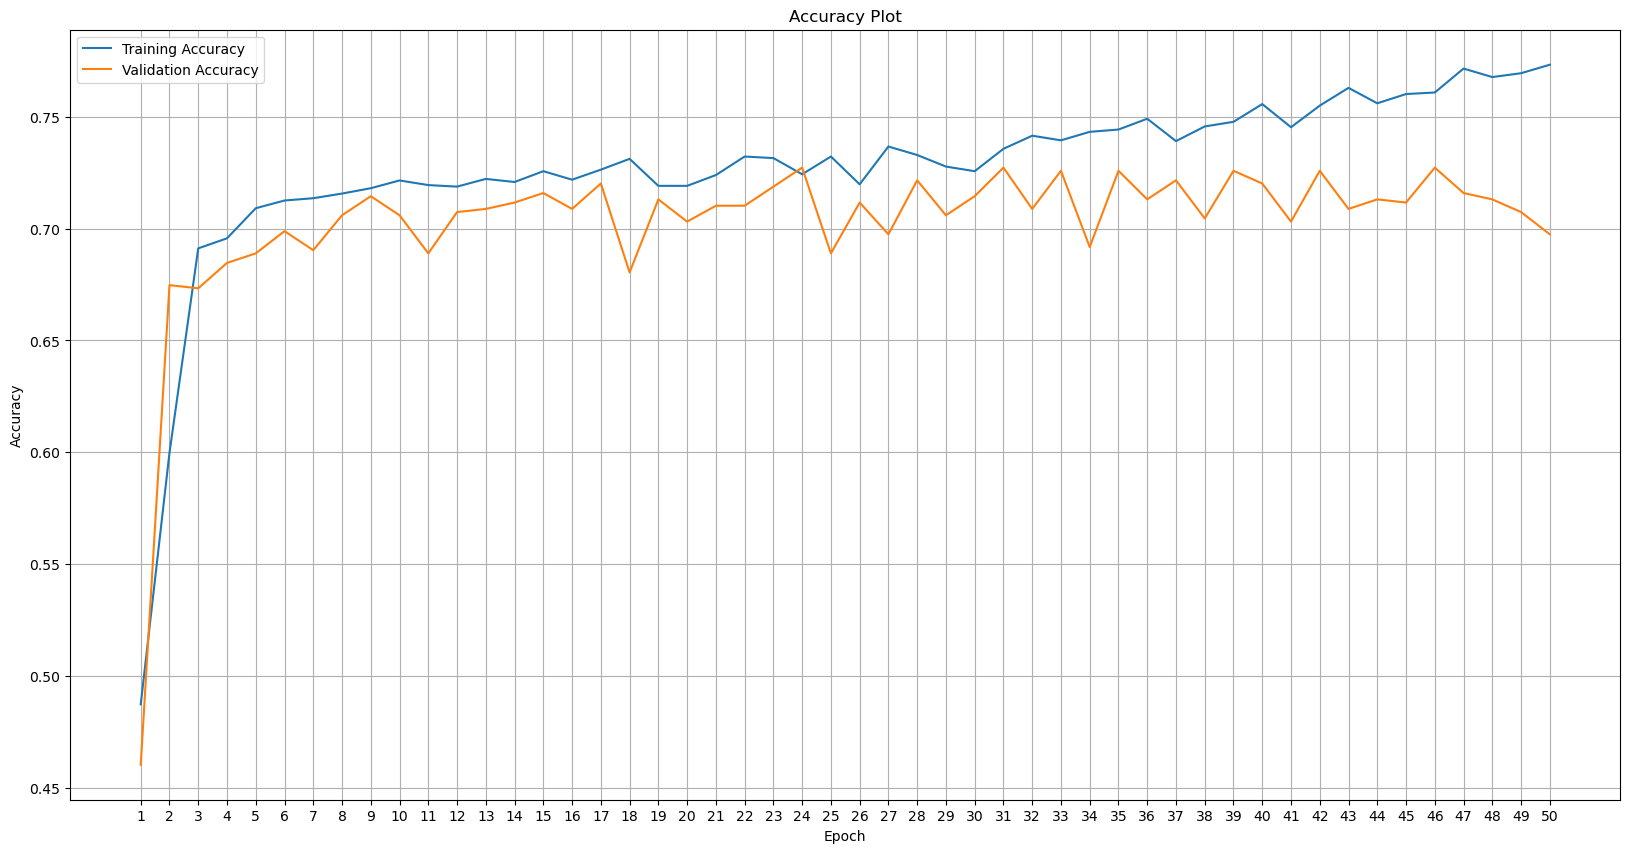

In [16]:
steps_per_epoch = 2930 // batch_size
validation_steps = 732 // batch_size
model.fit(
    train_pic,
    steps_per_epoch=steps_per_epoch, 
    epochs=50, 
    validation_data=test_pic,
    validation_steps=validation_steps,
    callbacks=[tm, plotter]
)

### 3. Give out Prediction Results

In [19]:
from keras.models import load_model
from math import ceil

trained_model = load_model('version1')

prediction_df = pd.read_csv('sample_submission.csv')
prediction_df['pic_id'] = prediction_df['id_code'].astype(str) + '.png'

In [20]:
prediction_pic = ImageDataGenerator(rescale=1/255)
pre_prediction = prediction_pic.flow_from_dataframe(
    dataframe=prediction_df,
    directory='test_images',
    x_col='pic_id',
    y_col=None,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    target_size=(image_size, image_size)
)

Found 1928 validated image filenames.


In [21]:
test_steps = ceil(pre_prediction.n / batch_size)

results = trained_model.predict(pre_prediction, steps=test_steps)

max_probability = np.argmax(results, axis=1)
prediction_df['diagnosis'] = max_probability

prediction_df.drop(columns=['pic_id'], inplace=True)
prediction_df.to_csv('submission.csv', index=False)

61/61 [==============================] - 42s 698ms/step
